- for each dataset, load projections, confidence, predictions, and label mask
- align z across dataset
- plot alignments w/ ground truth & predictions + labels, for each dataset for each labeled bit
(should we also compare euclidean labels?

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [71]:
from tfumap.semisupervised_keras import load_dataset
from tfumap.paths import ensure_dir, DATA_DIR, MODEL_DIR, FIGURE_DIR, save_fig

In [21]:
lpc_list = [4, 16, 64, 256, 1024, 'full']

In [25]:
from scipy.spatial import procrustes

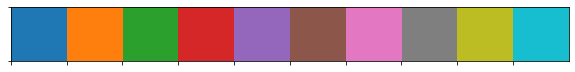

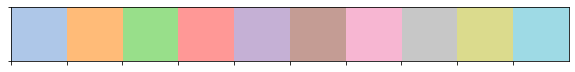

In [45]:
import seaborn as sns
tab20 = sns.color_palette('tab20', 20)
tab20_dark = tab20[::2]
tab20_light = tab20[1::2]
sns.palplot(tab20_dark)
sns.palplot(tab20_light)
from matplotlib.colors import ListedColormap
darkcmap = ListedColormap(sns.color_palette(tab20_dark).as_hex())
lightcmap = ListedColormap(sns.color_palette(tab20_light).as_hex())

In [46]:
projection_df = pd.DataFrame(
    columns=[
        "dataset",
        "z",
        "labels_per_class",
        "predictions",
        "confidence",
        "ground_truth",
        "labeled_examples",
        "procrustes_z"
    ]
)
for dataset in tqdm(dataset_list):
    # get latent projection over data
    z = np.load(MODEL_DIR/'projections' / dataset / 'umap-learn' / 'z.npy')
    for labels_per_class in tqdm(lpc_list, leave=False):
        # load data
        (
            X_train,
            X_test,
            X_labeled,
            Y_labeled,
            Y_masked,
            X_valid,
            Y_train,
            Y_test,
            Y_valid,
            Y_valid_one_hot,
            Y_labeled_one_hot,
            num_classes,
            dims
        ) = load_dataset(dataset, labels_per_class)
        
        embed_loc = DATA_DIR / 'ssl_embeddings' / dataset / str(labels_per_class)
        
        train_predictions = np.load(embed_loc / "train_predictions.npy")
        # save confidence
        train_confidence = np.load(embed_loc / "train_confidence.npy",)
        # save last layer z
        llz = np.load(embed_loc / "last_layer_embeddings.npy")
        
        z_umaplearn_align, z_umap_align, disparity = procrustes(z, llz)
        
        # save projections
        projection_df.loc[len(projection_df)] = [
            dataset,
            llz,
            labels_per_class,
            train_predictions,
            train_confidence,
            Y_train,
            Y_masked,
            z_umap_align
        ]
        

In [47]:
projection_df[:3]

,dataset,z,labels_per_class,predictions,confidence,ground_truth,labeled_examples,procrustes_z
0,mnist,"[[16.22878, 8.767908], [6.323791, 10.101354], ...",4,"[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, ...","[3.3430748, 3.1820168, 2.914947, 3.606132, 3.1...","[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, ...","[5.0, 0.0, 4.0, 1.0, 9.0, 2.0, 1.0, 3.0, 1.0, ...","[[0.0017525526697112137, 0.001749746789616528]..."
1,mnist,"[[0.91167474, 6.6644893], [-1.2304388, 14.5398...",16,"[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, ...","[3.646863, 3.1064856, 3.8345792, 4.0922995, 4....","[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, ...","[5.0, 0.0, 4.0, 1.0, 9.0, 2.0, 1.0, 3.0, 1.0, ...","[[0.00019718630585244617, 7.054440234416259e-0..."
2,mnist,"[[-5.068516, 12.675166], [-4.050523, -4.838134...",64,"[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, ...","[3.5989296, 3.5483937, 4.107306, 3.5297518, 3....","[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, ...","[5.0, 0.0, 4.0, 1.0, 9.0, 2.0, 1.0, 3.0, 1.0, ...","[[-0.001105449792628724, 0.0018172374691859741..."


### plot datasets
- for each dataset, plot data z + latent z

In [ ]:
def plot_dataset(z, y, s, alpha, cmap, ax, percentile = 99, padding = .1):
    sc = ax.scatter(
        z[:, 0],
        z[:, 1],
        c=y,
        cmap=cmap,
        s=s,
        alpha=alpha,
        rasterized=True,
    )
    x_min = np.percentile(z[:,0], 100 - percentile)
    x_max = np.percentile(z[:,0], percentile)
    y_min = np.percentile(z[:,1], 100 - percentile)
    y_max = np.percentile(z[:,1], percentile)
    xpad = (x_max - x_min)*padding
    ypad = (y_max - y_min)*padding
    #print(xpad, x_min, x_max)
    x_min-=xpad
    y_min-=ypad
    x_max+=xpad
    y_max+=ypad
    #print(xpad, x_min, x_max)
    xrange = x_max - x_min
    yrange = y_max - y_min
    if xrange > yrange:
        y_min -= (xrange - yrange)/2
        y_max += (xrange - yrange)/2
    if yrange > xrange:
        x_min -= (yrange - xrange)/2
        x_max += (yrange - xrange)/2
    
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    #print([x_max - x_min, y_max - y_min])
    #
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.axis('equal')
    plt.gca().set_aspect('equal', adjustable='box')
    ax.axis('off')

mnist


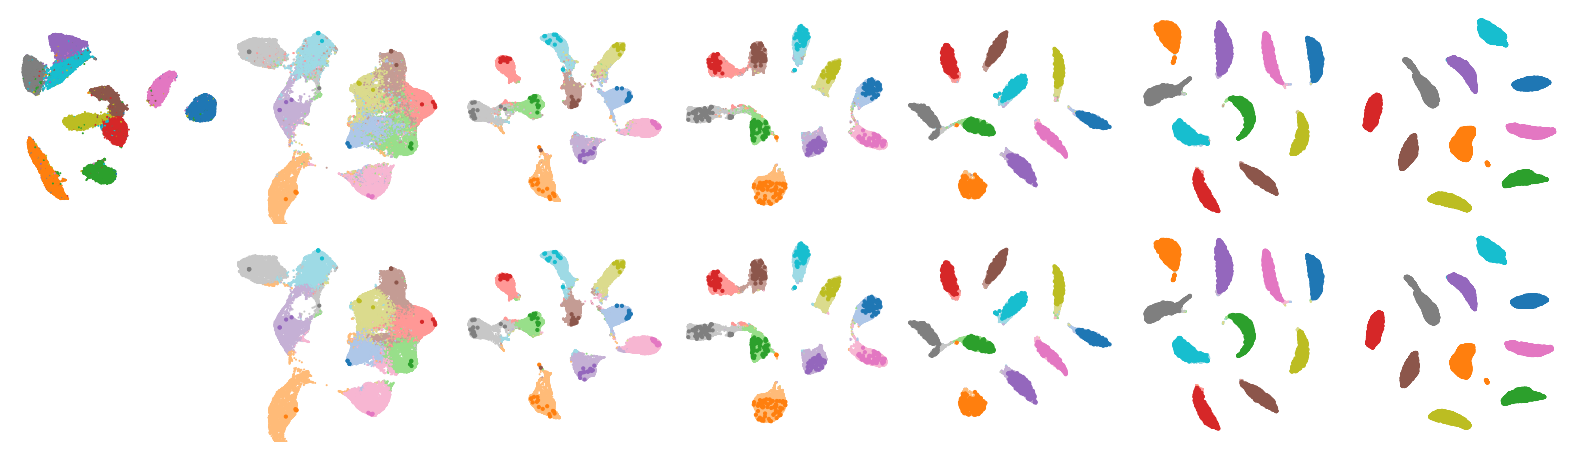

fmnist


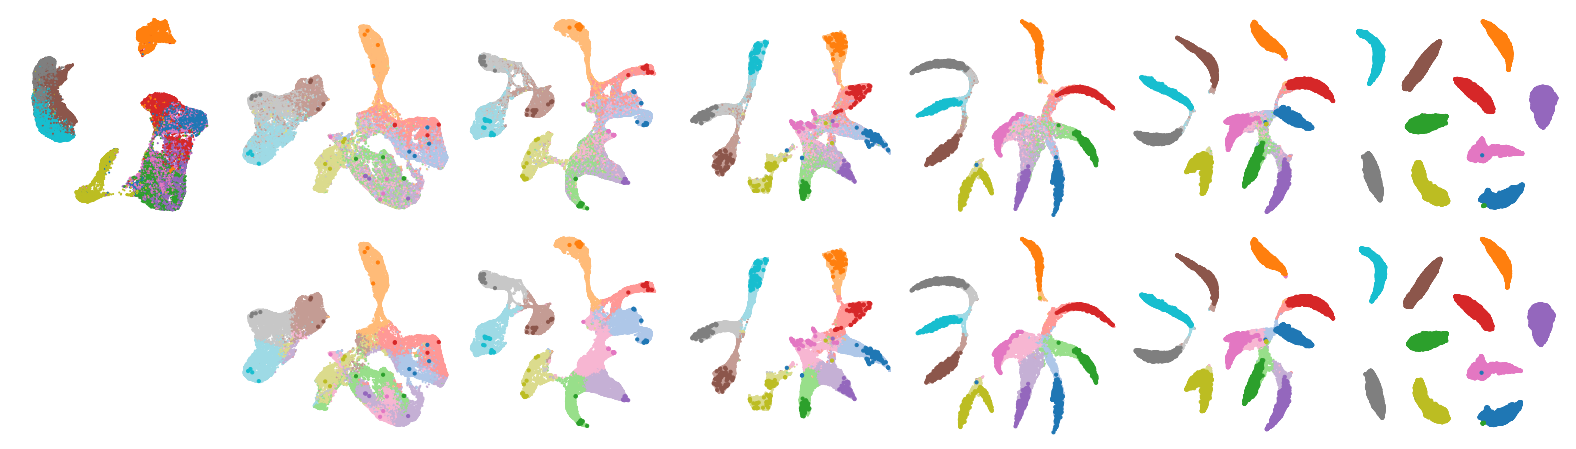

cifar10


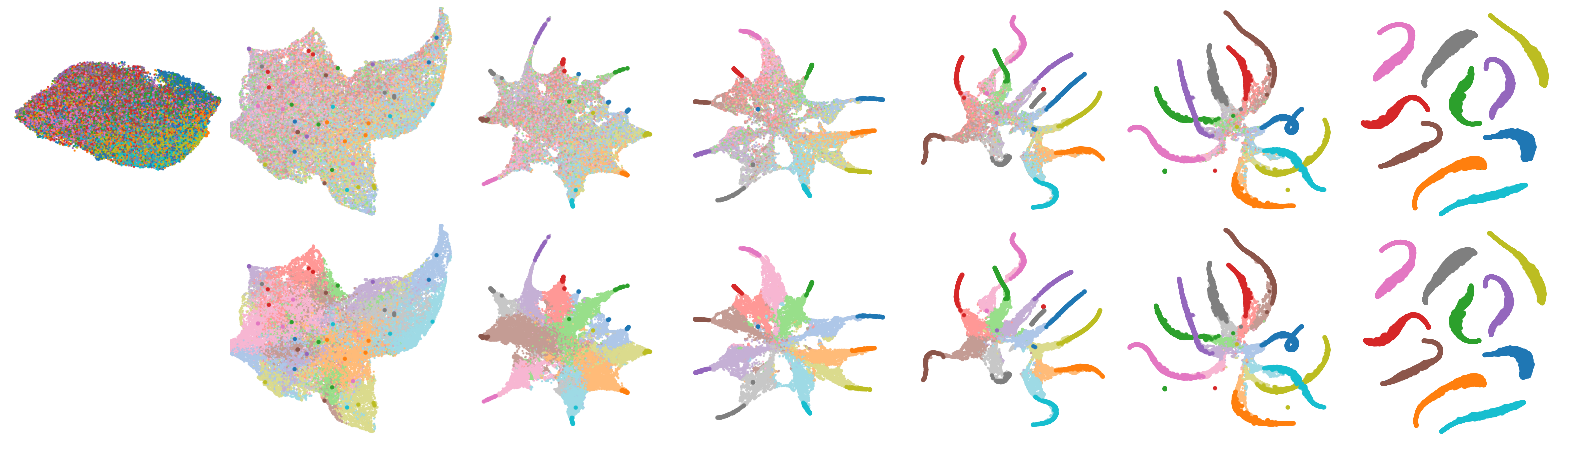

In [73]:
lpc_list = [4, 16, 64, 256, 1024, 'full']
ncols = len(lpc_list)+1
nrows = 2
zoom = 4
for dataset in tqdm(dataset_list):
    print(dataset)
    z = np.load(MODEL_DIR/'projections' / dataset / 'umap-learn' / 'z.npy')
    subset_ds = projection_df[projection_df.dataset == dataset]
    
    
    
    fig, axs = plt.subplots(ncols=ncols, nrows = nrows, figsize=(ncols*zoom, nrows*zoom), gridspec_kw={"wspace": 0, "hspace": 0},)
    for ax in axs.flatten():
        ax.axis('off')
    ax = axs[0, 0]


    plot_dataset(
        z=z,
        y=subset_ds.iloc[0].ground_truth,
        s=1,
        ax = axs[0, 0],
        alpha = 1,
        cmap= darkcmap
    )

    for idxi, (idx, row) in tqdm(enumerate(subset_ds.iterrows()), leave=False):
        for ri, c in zip([0,1], [row.ground_truth, row.predictions]):

            plot_dataset(
                z=row.procrustes_z,
                y=c,
                s=1,
                ax = axs[ri, idxi+1],
                alpha = 1,
                cmap= lightcmap
            )

            plot_dataset(
                z=row.procrustes_z[row.labeled_examples != -1],
                y=c[row.labeled_examples != -1],
                s=10,
                ax = axs[ri, idxi+1],
                alpha = 1,
                cmap= darkcmap
            )

    
    figdir = FIGURE_DIR / "latent_classifier_projections" / dataset
    ensure_dir(figdir)
    save_fig(figdir, dpi = 300, save_png=True, save_pdf=True, pad_inches = 0.1) # save_pdf=True,
        
    plt.show()
